In [1]:
import numpy as np

def sampen(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0

    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

In [2]:
from matplotlib import pyplot as plt
from matplotlib import collections as mc
import math
%matplotlib inline

import scipy
from scipy.signal import welch as welch
import multiprocessing
from joblib import Parallel, delayed
import os 
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

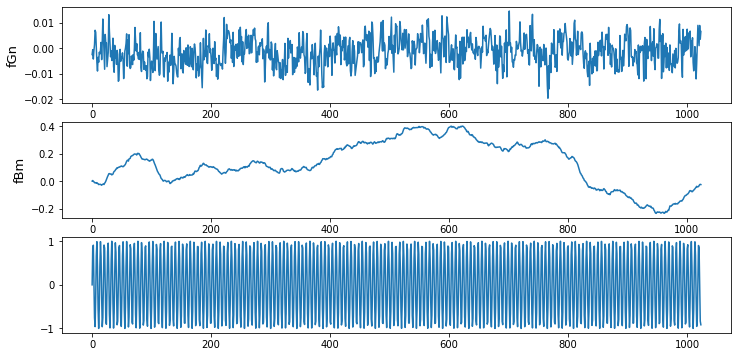

In [3]:
from fbm import FBM
signallen = 1024
f = FBM(n=signallen, hurst=0.75, length=1, method='daviesharte')
fgn_sample = f.fgn()
fbm_sample = f.fbm()

# Sine Wave
sine_sample = np.arange(0, signallen, 1);
sine_sample = np.sin(sine_sample)

import matplotlib.pyplot
#fgn_plot = matplotlib.pyplot.plot(fgn_sample)
matplotlib.pyplot.show()
fig = matplotlib.pyplot.figure(figsize=(12.0, 6.0))
axes1 = fig.add_subplot(3, 1, 1)
axes2 = fig.add_subplot(3, 1, 2)
axes3 = fig.add_subplot(3, 1, 3)

axes1.set_ylabel('fGn', fontsize=13)
axes1.plot(fgn_sample)
axes2.set_ylabel('fBm', fontsize=13)
axes2.plot(fbm_sample)

axes3.plot(sine_sample)
#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('fGnfBm.png', dpi=300, bbox_inches='tight' )

In [4]:
def signrescale(inputsig):
    outputsig = (inputsig- inputsig.min(axis=0)) / (inputsig.max(axis=0) - inputsig.min(axis=0))
    return outputsig

In [5]:
fgn_sample_manual_scale = signrescale(fgn_sample)
fbm_sample_manual_scale = signrescale(fbm_sample)
sine_sample_manual_scale = signrescale(sine_sample)

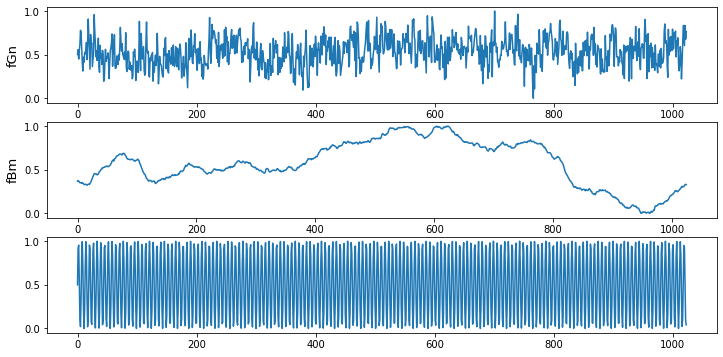

In [6]:
matplotlib.pyplot.show()
fig = matplotlib.pyplot.figure(figsize=(12.0, 6.0))
axes1 = fig.add_subplot(3, 1, 1)
axes2 = fig.add_subplot(3, 1, 2)
axes3 = fig.add_subplot(3, 1, 3)

axes1.set_ylabel('fGn', fontsize=13)
axes1.plot(fgn_sample_manual_scale)
axes2.set_ylabel('fBm', fontsize=13)
axes2.plot(fbm_sample_manual_scale)
axes3.plot(sine_sample_manual_scale)

In [7]:
nperseg = math.floor(signallen/8)
noverlap = math.floor(nperseg/2)

In [8]:
wfgn = welch(fgn_sample_manual_scale, fs = 1, nperseg = nperseg, noverlap = noverlap)
wfbm = welch(fbm_sample_manual_scale, fs = 1, nperseg = nperseg, noverlap = noverlap)
wsine = welch(sine_sample_manual_scale, fs = 1, nperseg = nperseg, noverlap = noverlap)

In [9]:
def BetaHurst(inputsig):
    lx = np.log10(inputsig[0])[1:].reshape((-1, 1))
    ly = np.log10(inputsig[1])[1:]
    wmodel = LinearRegression().fit(lx, ly)
    negbeta = wmodel.coef_
    beta = negbeta*-1
    print('Beta =', round(float(beta),2))
    print('H =', (round(float(beta),2)+1)/2)

In [10]:
BetaHurst(wfgn)

Beta = 0.54
H = 0.77


/tmp/ipykernel_661161/449157958.py:2: RuntimeWarning: divide by zero encountered in log10
  lx = np.log10(inputsig[0])[1:].reshape((-1, 1))


In [11]:
BetaHurst(wfbm)

Beta = 2.44
H = 1.72


/tmp/ipykernel_661161/449157958.py:2: RuntimeWarning: divide by zero encountered in log10
  lx = np.log10(inputsig[0])[1:].reshape((-1, 1))


In [12]:
BetaHurst(wsine)

Beta = 2.94
H = 1.97


/tmp/ipykernel_661161/449157958.py:2: RuntimeWarning: divide by zero encountered in log10
  lx = np.log10(inputsig[0])[1:].reshape((-1, 1))


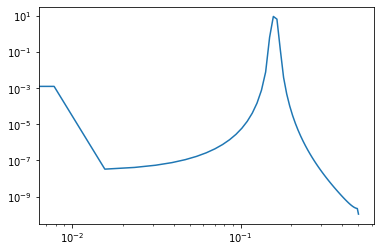

In [13]:
axes = plt.gca()

plt.loglog(wsine[0],wsine[1])

In [16]:
sampen(fgn_sample_manual_scale,3,np.std(fgn_sample_manual_scale)*0.6)

1.0642475796988295

In [17]:
sampen(fbm_sample_manual_scale,3,np.std(fbm_sample_manual_scale)*0.6)

0.02312467812653574

In [18]:
sampen(sine_sample_manual_scale,3,np.std(sine_sample_manual_scale)*0.6)

0.00801419988197161

# Brain

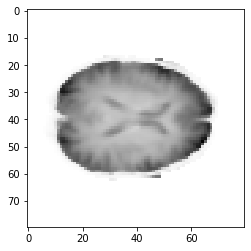

In [19]:
example_slice = '/home/weberam2/Dropbox/AssistantProf_BCCHRI/Projects/Fractal/FractalData/2020-09-17_BCCHR_test_AlexW/derivatives/func/FracTool_run1/filtered_func_data_clean.nii.gz'
slice_img = nib.load(example_slice, mmap=False)
slice_array = slice_img.get_fdata()
slice_sq = slice_array[:,:,30,:]
imgplot = plt.imshow(slice_sq[:,:,1],cmap='Greys',  interpolation='nearest')
plt.show()

## GM

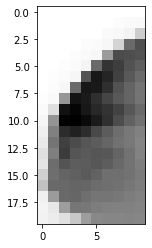

In [20]:
slice_sq = slice_array[20:40,10:20,30,:]
imgplot = plt.imshow(slice_sq[:,:,1],cmap='Greys',  interpolation='nearest')
plt.show()

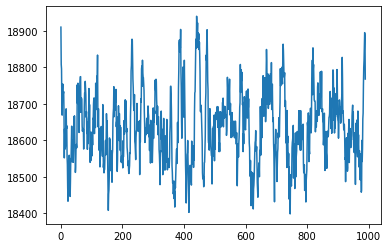

In [21]:
voxelg = slice_array[30,15,30,:]
plt.plot(voxelg)

0.6


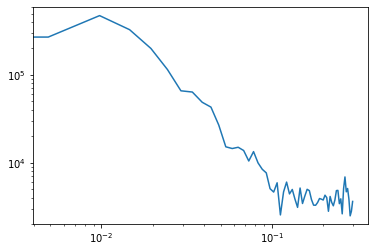

In [22]:
TR = slice_img.header.get_zooms()
TR = TR[3]
print(TR)
nperseg = math.floor(len(voxelg)/8)
noverlap = math.floor(nperseg/2)
wg = welch(voxelg, fs = TR, nperseg = nperseg, noverlap = noverlap)
axes = plt.gca()
axes.set_ylim([2000,600000])
plt.loglog(wg[0],wg[1])

In [24]:
from sklearn.linear_model import LinearRegression
xg = np.log10(wg[0])[1:].reshape((-1, 1))
yg = np.log10(wg[1])[1:]
modelg = LinearRegression().fit(xg, yg)
negbetag = modelg.coef_
betag = negbetag*-1
print('Beta =', round(float(betag),2))
print('H =', (round(float(betag),2)+1)/2)
print('SampEnt =', round(sampen(voxelg,3,0.6*np.std(voxelg)),2))

Beta = 1.35
H = 1.175
SampEnt = 0.59


/tmp/ipykernel_661161/191257799.py:2: RuntimeWarning: divide by zero encountered in log10
  xg = np.log10(wg[0])[1:].reshape((-1, 1))


## CSF

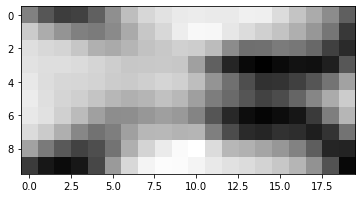

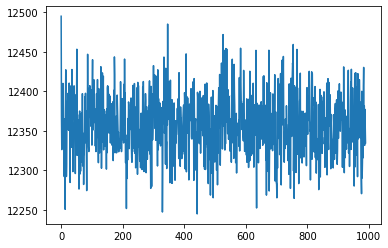

In [25]:
slice_mid = slice_array[35:45,30:50,30,:]
imgplot = plt.imshow(slice_mid[:,:,1],cmap='Greys',  interpolation='nearest')
plt.show()
voxelc = slice_array[38,45,30,:]
plt.plot(voxelc)

/tmp/ipykernel_661161/4137825126.py:5: RuntimeWarning: divide by zero encountered in log10
  xc = np.log10(wc[0])[1:].reshape((-1, 1))


Beta = 0.08
H = 0.54
SampEnt = 0.32


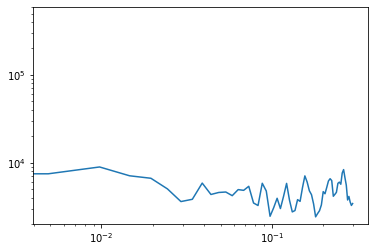

In [26]:
wc = welch(voxelc, fs = TR, nperseg = nperseg, noverlap = noverlap)
axes = plt.gca()
axes.set_ylim([2000,600000])
plt.loglog(wc[0],wc[1])
xc = np.log10(wc[0])[1:].reshape((-1, 1))
yc = np.log10(wc[1])[1:]
modelc = LinearRegression().fit(xc, yc)
negbetac = modelc.coef_
betac = negbetac*-1
print('Beta =', round(float(betac),2))
print('H =', (round(float(betac),2)+1)/2)
print('SampEnt =', round(sampen(voxelc,3,0.6*np.std(voxelg)),2))

## White Matter

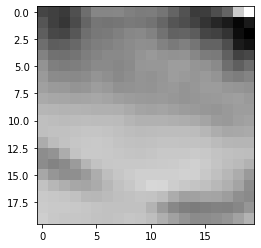

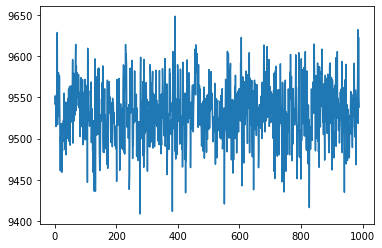

In [27]:
slice_sq = slice_array[20:40,30:50,30,:]
imgplot = plt.imshow(slice_sq[:,:,1],cmap='Greys',  interpolation='nearest')
plt.show()
voxelw = slice_array[30,40,30,:]
plt.plot(voxelw)



/tmp/ipykernel_661161/1685803150.py:5: RuntimeWarning: divide by zero encountered in log10
  xw = np.log10(ww[0])[1:].reshape((-1, 1))


Beta = 0.2
H = 0.6
SampEnt = 0.27


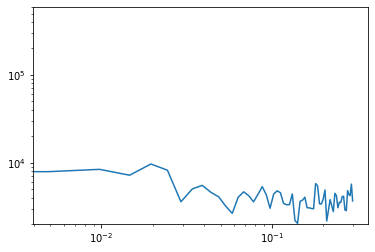

In [28]:
ww = welch(voxelw, fs = TR, nperseg = nperseg, noverlap = noverlap)
axes = plt.gca()
axes.set_ylim([2000,600000])
plt.loglog(ww[0],ww[1])
xw = np.log10(ww[0])[1:].reshape((-1, 1))
yw = np.log10(ww[1])[1:]
modelw = LinearRegression().fit(xw, yw)
negbetaw = modelw.coef_
betaw = negbetaw*-1
print('Beta =', round(float(betaw),2))
print('H =', (round(float(betaw),2)+1)/2)
print('SampEnt =', round(sampen(voxelw,3,0.6*np.std(voxelg)),2))